In [1]:
import pyomo.environ as pyo

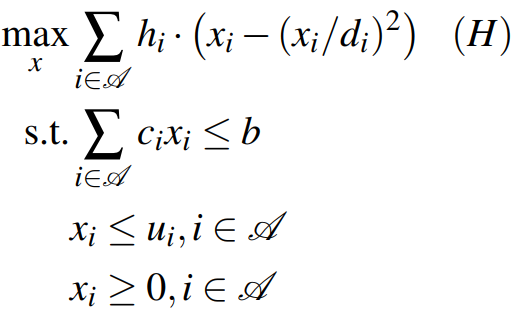

# approach 1

In [2]:
def IC_model(A,h,d,c,b,u):
    model = pyo.ConcreteModel(name = "(H)")
    
    def x_bounds(i):
        return (0,u[i])
    model.x = pyo.Var(A, bounds = x_bounds)
    
    def obj_rule(model):
        return sum(  h[i]*(model.x[i] - (model.x[i]/d[i])**2) for i in A  )
    model.obj = pyo.Objective(rule = obj_rule, sense = pyo.maximize)
    #model.obj = pyo.Objective(  expr = h[i]*(model.x[i] - (model.x[i]/d[i])**2) for i in A, sense = pyo.maximize  )
    
    model.budgetcon = pyo.Constraint(expr = sum(c[i]*model.x[i] for i in A) <= b)
    #def con_rule(model):
    #    return sum(c[i]*model.x[i] for i in A) <= b
    #model.budgetcon = pyo.Constraint(rule = con_rule)
    
    return model

# approach 2

In [3]:
def IC_model_dic(ICD):
    # ICD is a dictionary with the data for the problem
    model = pyo.ConcreteModel(name = "(H)")
    
    model.A = pyo.Set(initialize=ICD["A"])
    
    model.h = pyo.Param(model.A, initialize=ICD["h"])
    model.d = pyo.Param(model.A, initialize=ICD["d"])
    model.c = pyo.Param(model.A, initialize=ICD["c"])
    model.u = pyo.Param(model.A, initialize=ICD["u"])
    model.b = pyo.Param(initialize=ICD["b"])
    
    def x_bounds_rule(model,i):
        return (0, model.u[i])
    model.x = pyo.Var(model.A, bounds = x_bounds_rule) # model.A specifies the number of Xs
    
    def obj_rule(model):
        return sum( mode.h[i]*( model.x[i] - (model.x[i]/model.d[i])**2 ) for i in model.A )
    model.obj = pyo.Objective(rule = obj_rule, sense = pyo.maximize)
    
    def budget_rule(model):
        return (sum( model.c[i]*model.x[i] for i in model.A ) <= model.b)
    model.budgetcon = pyo.Constraint(rule = budget_rule)
    
    return model

## change the model to be linear and solve it

In [10]:
def IC_model_linear(ICD):
    # ICD is a dictionary with the data for the problem
    model = pyo.ConcreteModel(name = "(H)")
    
    model.A = pyo.Set(initialize=ICD["A"])
    
    model.h = pyo.Param(model.A, initialize=ICD["h"])
    model.d = pyo.Param(model.A, initialize=ICD["d"])
    model.c = pyo.Param(model.A, initialize=ICD["c"])
    model.u = pyo.Param(model.A, initialize=ICD["u"])
    model.b = pyo.Param(initialize=ICD["b"])
    
    def x_bounds_rule(model,i):
        return (0, model.u[i])
    model.x = pyo.Var(model.A, bounds = x_bounds_rule) # model.A specifies the number of Xs
    
    def obj_rule(model):
        return sum( model.h[i]*(1 - model.u[i]/model.d[i]**2) * model.x[i] for i in model.A )
    model.obj = pyo.Objective(rule = obj_rule, sense = pyo.maximize)
    
    def budget_rule(model):
        return (sum( model.c[i]*model.x[i] for i in model.A ) <= model.b)
    model.budgetcon = pyo.Constraint(rule = budget_rule)
    
    return model

# Solve

In [19]:
ICD = {
    "A" : ["I_C_Scoops", "Peanuts"],
    "h" : {"I_C_Scoops": 1, "Peanuts": 0.1},
    "d" : {"I_C_Scoops": 5, "Peanuts": 27},
    "c" : {"I_C_Scoops": 3.14, "Peanuts": 0.2718},
    "b" : 12,
    "u" : {"I_C_Scoops": 100, "Peanuts": 40.6}
}

model = IC_model_linear(ICD)

In [20]:
opt = pyo.SolverFactory("glpk")

In [21]:
results = opt.solve(model) # solves and updates model

In [22]:
print(pyo.check_optimal_termination(results)) # shows whether the optimal solution is found or not

True


In [23]:
model.display()

Model '(H)'

  Variables:
    x : Size=2, Index=A
        Key        : Lower : Value : Upper : Fixed : Stale : Domain
        I_C_Scoops :     0 :   0.0 :   100 : False : False :  Reals
           Peanuts :     0 :  40.6 :  40.6 : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 3.8338875171467763

  Constraints:
    budgetcon : Size=1
        Key  : Lower : Body     : Upper
        None :  None : 11.03508 :  12.0
